### General Concept

1. Given a pdf file of a bank transaction with multiple pages, get png/jpg of each page.
2. With png/jpg, detect relevant texts (e.g. Tanggal, Keterangan, Mutasi)
3. Put detected text into a DataFrame to be converted into a CSV file that is seperated by semicolons ;

Current issue: Data categorization is messy

Current solution: Use more explicit arrays

### Import Dump

In [1]:
import cv2
import pandas as pd
import fitz
import matplotlib.pyplot as plt
import pytesseract

c:\Users\paoma\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Scanning

First we convert the pdf into a png per page

In [2]:
pdf_name = "Adi.pdf"

doc = fitz.open(pdf_name)

for page in doc:
    pix = page.get_pixmap(dpi=600)
    pix.save("page-%i.png" % page.number)

Use an OCR (optical character recognition) model for reading text

In [3]:
# define tesseract OCT model 
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

Read the images to be put into an Image object in cv2

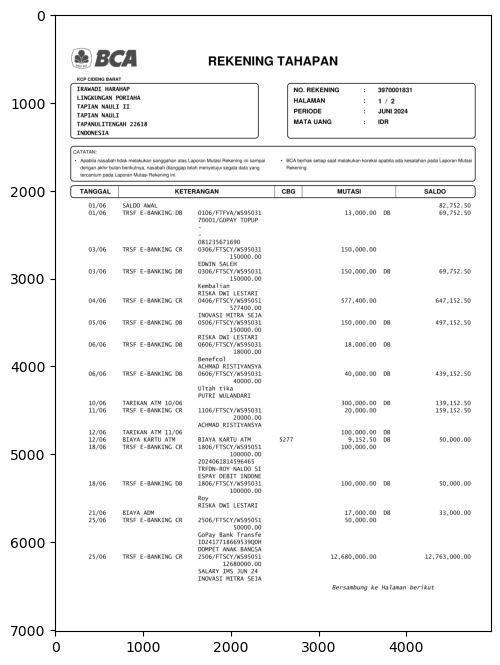

In [248]:
# read png
page = cv2.imread("Adi-page-0.png")

# to grayscale for model to easily process
page = cv2.cvtColor(page, cv2.COLOR_BGR2GRAY)

# show page image
plt.figure(figsize=(30,8))
plt.imshow(page, cmap="gray")

Resize the image so that the model processes it faster (optional; sometimes its faster)

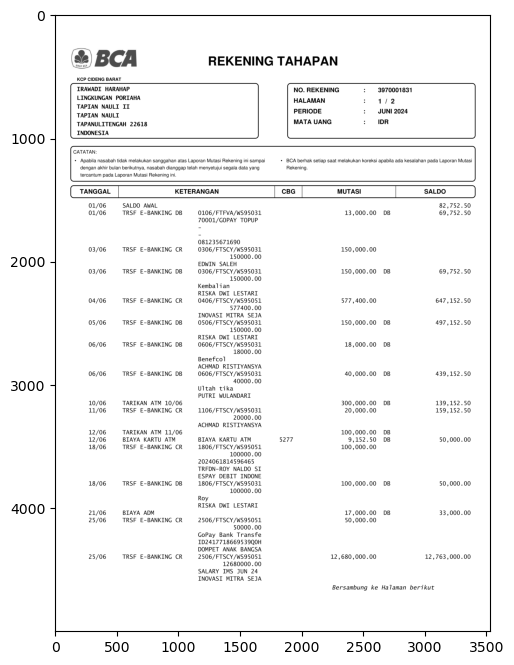

In [5]:
# flexible dimension function
def flexible_dim(img, width=0,height=0):
    if width != 0 and height == 0:
        aspect_ratio = width / img.shape[1]
        height = int(img.shape[0] * aspect_ratio)
        return (width, height)
    elif height != 0 and width == 0:
        aspect_ratio = height / img.shape[0]
        width = int(img.shape[1] * aspect_ratio)
        return (width, height)
    else:
        print("Only change one dimension!")
        return None

# dimension with proper scaling
dim = flexible_dim(page, height=5000)

page = cv2.resize(page, dsize=dim, interpolation=cv2.INTER_AREA)

plt.figure(figsize=(30,8))
plt.imshow(page, cmap="gray")

The important part of this file is below the row with "Tanggal, Keterangan, ...". So crop this part. Assume that the height ratio proportion of this bank statement to be stable. 

The height crop in this image should be around the 2050th pixel and the image is 7017 pixels high. So the ratio is 2050/7017 which is around 0.298. So crop at the 29.8% height of the image regardless of the image size.

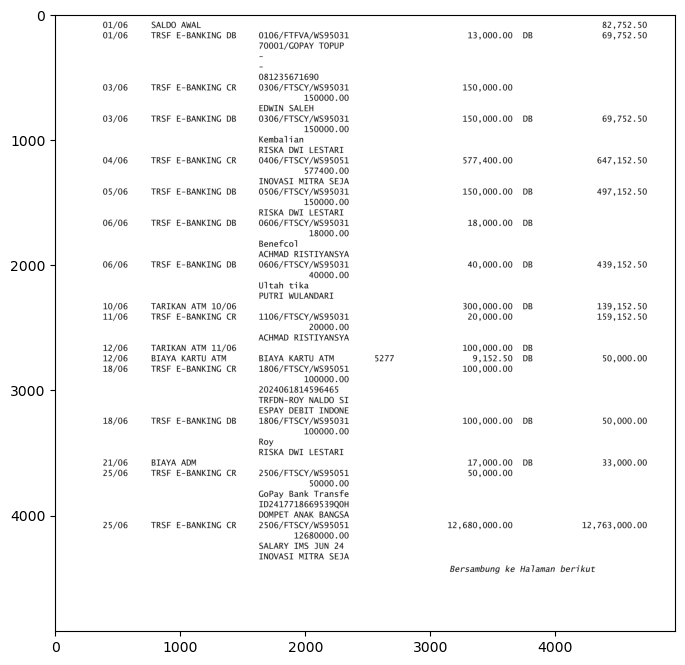

In [249]:
# get page height
page_height = page.shape[0]

page = page[int(page_height * 0.298):, :]

plt.figure(figsize=(30,8))
plt.imshow(page, cmap="gray")


Create a threshold for creating pure monochrome image

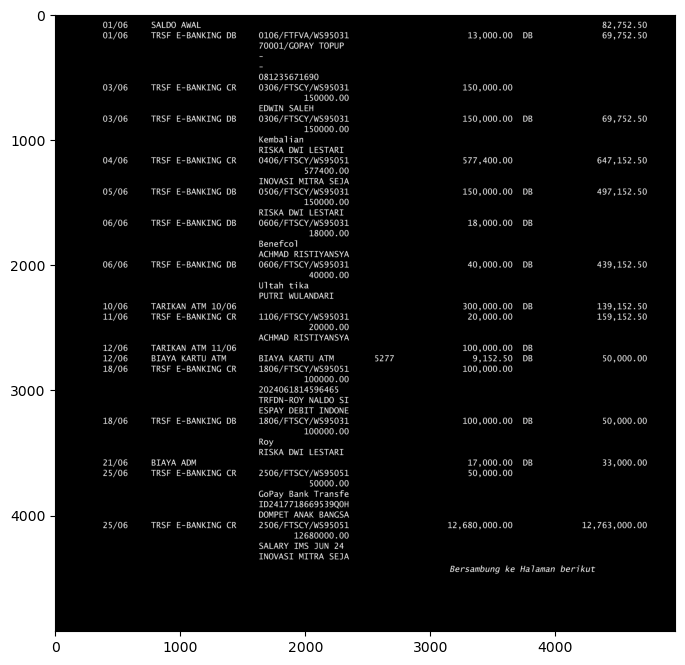

In [250]:
# define threshold
retval, thresh = cv2.threshold(page, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

# show monochrome image
plt.figure(figsize=(30,8))
plt.imshow(thresh, cmap="gray")

Extract text using contours (rectangles around text) more simply for the model to detect characters.

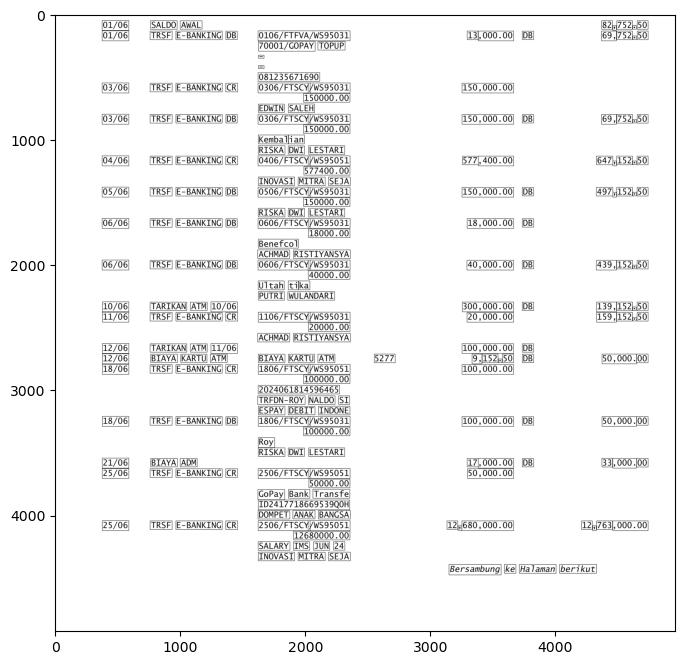

In [251]:
# dilation parameter; bigger tuple = smaller rectangle
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 20))

# apply dilation to the thresholded monochrome image
dilation = cv2.dilate(thresh, rect_kernel, iterations=1)

# find contours and rectangles
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# copy grayscale image from earlier to see the contours
page_copy = page.copy()

# make contour list to store text and its corresponding coordinates
cnt_list = []

# loop for each contour detected
for cnt in contours:

    # get coordinates of contours
    x, y, w, h = cv2.boundingRect(cnt)

    # draw rectangle for each contour
    cv2.rectangle(page_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # crop text block by rectangle text block
    crop = page_copy[y:y+h, x:x+w]

    # use ocr model cropped image
    text = pytesseract.image_to_string(crop, config="--psm 13")

    # store coordinates and text
    cnt_list.append([x, y, text])

plt.figure(figsize=(30,8))
plt.imshow(page_copy, cmap="gray")

Sort text from left to right and from up to down

In [252]:
sorted_list = sorted(cnt_list, key = lambda x: x[0]) # sort by width first
sorted_list = sorted(sorted_list, key = lambda x: x[1]) # then height

sorted_list

[[376, 43, '01/06\n'],
 [763, 45, 'SALDO\n'],
 [4364, 45, '82\n'],
 [4486, 45, '752\n'],
 [4649, 45, '50\n'],
 [999, 46, 'AWAL\n'],
 [4454, 84, '|\n'],
 [4614, 84, '| |\n'],
 [376, 126, '01/06\n'],
 [1621, 126, '0106/FTFVA/WS95031\n'],
 [759, 128, 'TRSF\n'],
 [965, 128, 'E-BANKING\n'],
 [3291, 128, '13\n'],
 [3380, 128, ', 000.00\n'],
 [4364, 128, '69,\n'],
 [4486, 128, '752\n'],
 [4649, 128, '50\n'],
 [1364, 129, 'DB\n'],
 [3731, 129, 'DB\n'],
 [4614, 167, '| |\n'],
 [1624, 209, '70001/GOPAY\n'],
 [2099, 211, 'TOPUP\n'],
 [1624, 321, '—\n'],
 [1624, 404, '—\n'],
 [1621, 461, '081235671690\n'],
 [376, 543, '03/06\n'],
 [1621, 543, '0306/FTSCY,\n'],
 [2021, 543, '/WS95031\n'],
 [759, 545, 'TRSF\n'],
 [965, 545, 'E-BANKING\n'],
 [1363, 545, 'CR\n'],
 [3250, 545, '150,000.00\n'],
 [1984, 628, '150000.00\n'],
 [1863, 711, 'SALEH\n'],
 [1624, 712, 'EDWIN\n'],
 [376, 793, '03/06\n'],
 [1621, 793, '0306/FTSCY,\n'],
 [2021, 793, '/WS95031\n'],
 [759, 795, 'TRSF\n'],
 [965, 795, 'E-BANKING\n'],

Make into DataFrame for 2D array manipulation to make it cleaner

In [253]:
# create dataframe
df = pd.DataFrame(sorted_list)
df.columns = ["x", "y", "Text"]

# omit trivial texts
df = df.drop(df[(df.Text == "")].index)

# Remove the \n in text
df["Text"] = df["Text"].str.replace("\n", "")
df = df.drop(df[(df.Text == "|") | (df.Text == "| |")].index)

df.head(20)

,x,y,Text
0,376,43,01/06
1,763,45,SALDO
2,4364,45,82
3,4486,45,752
4,4649,45,50
5,999,46,AWAL
8,376,126,01/06
9,1621,126,0106/FTFVA/WS95031
10,759,128,TRSF
11,965,128,E-BANKING


Each perceieved row in the image is seen to have a range of 2-5 pixels in its y (e.g. 43, 44, 45) by the model but it is important to make it so that it is in the same y that the paper is actually trying to tell

So replace a row's y point (defined as the top left of the row or contour) and everything that is near that y point (y+5) to be y

(To be optimized with df functions; or not? the runtime is 0s)

In [254]:
r = 0

for i in range(df.shape[0]):
    if i == 0:
        r = df["y"].iloc[0]

    y = df["y"].iloc[i]

    if y <= r+5:
        df["y"].iloc[i] = r
    else:
        r = y

# sort again left to right, top to bottom
df = df.sort_values(by=["y", "x"])

df.tail(50)

C:\Users\paoma\AppData\Local\Temp\ipykernel_3180\2007617871.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["y"].iloc[i] = r
C:\Users\paoma\AppData\Local\Temp\ipykernel_3180\2007617871.py:10: SettingWithCopyWarning: 
A value is tryin

,x,y,Text
189,1623,3461,RISKA
191,1862,3461,DwI
190,2025,3461,LESTARL
192,377,3543,21/06
198,764,3543,BIAYA
199,999,3543,ADM
193,3291,3543,17
194,3380,3543,", 000.00"
200,3731,3543,DB
195,4367,3543,33


A row in the transaction is defined by each date's position. Similarly in the desired CSV, the same row shall have all of its elements with it. 

The date's x is always the most left (+/-5) so get the smallest x and split the dataset based on when each date is detected per row.

It is also desirable to make every element have its x known to detect which column it is in

Create a new DataFrame where columns store each column in the page (Tanggal, Keterangan, CBG, Mutasi, Saldo) and put each transaction row into one row. Keterangan will have multiple string elements concatenated

In [255]:
t = pd.DataFrame(columns=["Tanggal", "Keterangan 1", "Keterangan 2", "CBG", "Mutasi", "Saldo"])

Find each left x coordinate of each column. First do a manual search of each x coordinate by plotting vertical lines in the page

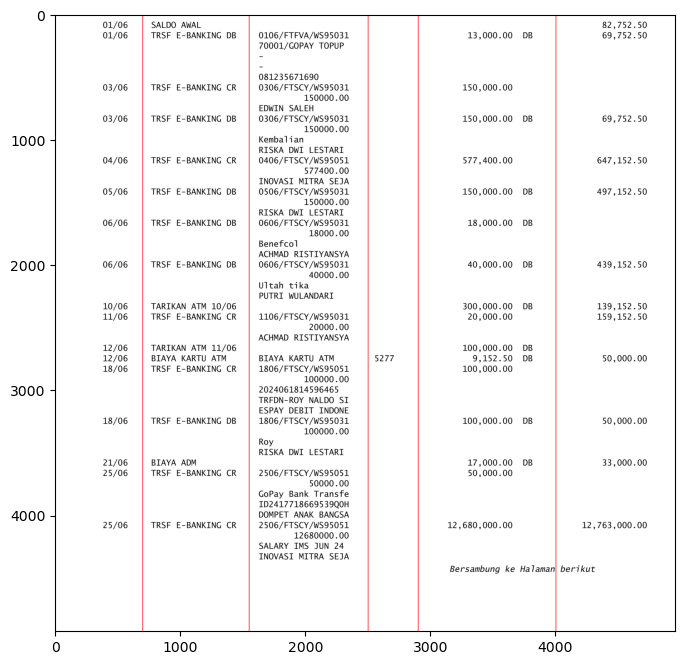

In [256]:
page_lines = page.copy()
page_lines = cv2.cvtColor(page_lines, cv2.COLOR_GRAY2BGR)

cv2.line(page_lines, (700, 0), (700, page.shape[0]), (255, 0, 0), 4, cv2.LINE_AA)
cv2.line(page_lines, (1550, 0), (1550, page.shape[0]), (255, 0, 0), 4, cv2.LINE_AA)
cv2.line(page_lines, (2500, 0), (2500, page.shape[0]), (255, 0, 0), 4, cv2.LINE_AA)
cv2.line(page_lines, (2900, 0), (2900, page.shape[0]), (255, 0, 0), 4, cv2.LINE_AA)
cv2.line(page_lines, (4000, 0), (4000, page.shape[0]), (255, 0, 0), 4, cv2.LINE_AA)

plt.figure(figsize=(30, 8))
plt.imshow(page_lines)

Therefore for each column, its x coordinates are:
- Tanggal: 0 < x < 700
- Keterangan 1: 700 < x < 1550
- Keterangan 2: 1550 < x < 2500
- CBG: 2500 < x < 2900
- Mutasi: 2900 < x < 4000
- Saldo: 4000 < x < `page.shape[1]`

In [258]:
tanggal_text = ""; keterangan1_text = ""; keterangan2_text = ""; cbg_text = ""; mutasi_text = ""; saldo_text = ""
tanggals = []; keterangan1s = []; keterangan2s = []; cbgs = []; mutasis = []; saldos = []

# prevents summary at the end of pdf to be added
exit = 0 # if SALDO and AWAL is detected in columns keterangan1 and keterangan2 correspondingly, append arrays and break

df = df._append({"x": 500, "y": 0, "Text": "a"}, ignore_index=True)

for i in range(df.shape[0]):
    x = df["x"].iloc[i]
    text = df["Text"].iloc[i]
    
    if 0 < x < 700:
        if keterangan1_text != "":
            tanggals.append(tanggal_text)
            keterangan1s.append(keterangan1_text)
            keterangan2s.append(keterangan2_text)
            cbgs.append(cbg_text)
            mutasis.append(mutasi_text)
            saldos.append(saldo_text)

            tanggal_text = ""; keterangan1_text = ""; keterangan2_text = ""; cbg_text = ""; mutasi_text = ""; saldo_text = ""

        tanggal_text += text + ""
    elif 700 < x < 1550:
        if text != "SALDO":
            keterangan1_text += text + " "
        else:
            exit += 1
    elif 1550 < x < 2500:
        keterangan2_text += text + " "
        if "AWAL" in text:
            exit += 1
    elif 2500 < x < 2900:
        cbg_text += text + " "
    elif 2900 < x < 4000:
        mutasi_text += text + " "
    elif 4000 < x < page.shape[1]:
        saldo_text += text + " "

    if exit == 2:
        tanggals.append(tanggal_text)
        keterangan1s.append(keterangan1_text)
        keterangan2s.append(keterangan2_text)
        cbgs.append(cbg_text)
        mutasis.append(mutasi_text)
        saldos.append(saldo_text)

        tanggal_text = ""; keterangan1_text = ""; keterangan2_text = ""; cbg_text = ""; mutasi_text = ""; saldo_text = ""

        break

t = pd.DataFrame({
            "Tanggal": tanggals,
            "Keterangan 1": keterangan1s,
            "Keterangan 2": keterangan2s,
            "CBG": cbgs,
            "Mutasi": mutasis,
            "Saldo": saldos 
        })

t = t[t["Keterangan 1"].str.contains("AWAL") == False]
t = t[t["Tanggal"].str.contains("a") == False] # delete

t

,Tanggal,Keterangan 1,Keterangan 2,CBG,Mutasi,Saldo
1,01/06,TRSF E-BANKING DB,0106/FTFVA/WS95031 70001/GOPAY TOPUP — — 08123...,,"13 , 000.00 DB","69, 752 50"
2,03/06,TRSF E-BANKING CR,"0306/FTSCY, /WS95031 150000.00 EDWIN SALEH",,"150,000.00",
3,03/06,TRSF E-BANKING DB,"0306/FTSCY, /WS95031 150000.00 Kembal jan RISK...",,"150,000.00 DB","69, 752 50"
4,04/06,TRSF E-BANKING CR,"0406/FTSCY, /WS95051 577400.00 TNOVASTLI MITRA...",,577 » 400.00,647 152 50
5,05/06,TRSF E-BANKING DB,"0506/FTSCY, /WS95031 150000.00 RISKA DwI LESTARL",,"150,000.00 DB",497 152 50
6,06/06,TRSF E-BANKING DB,"0606/FTSCY, /WS95031 18000.00 Benefcol ACHMAD ...",,"18,000.00 DB",
7,06/06,TRSF E-BANKING DB,"0606/FTSCY, /WS95031 40000.00 Ultah ti ka PUTR...",,"40,000.00 DB","439, 152 50"
8,10/06,TARIKAN ATM 10/06,,,"300,000.00 DB","139, 152 50"
9,11/06,TRSF E-BANKING CR,"1106/FTSCY, /WS95031 20000.00 ACHMAD RISTIYANSYA",,"20,000.00","159, 152 50"
10,12/06,TARIKAN ATM 11/06,,,"100,000.00 DB",


String postprocessing so the csv looks neater

In [259]:
# remove every element's last character (which is some unnecessary space)
for col in t.columns:
    if col != "Tanggal":
        t[col] = t[col].str[:-1]

In [260]:
# remove spacing in saldo
t["Mutasi"] = t["Mutasi"].str.replace(" ", "")

# remove string in saldo
for i in range(t.shape[0]):
    m = t["Mutasi"].iloc[i]

    if m != "":
        for c in range(len(m)):
            if m[-1:].isalpha():
                m = m[:-1]

        if m[-3:-2] != ".":
            m = m[:-2] + "." + m[-2:]

        t["Mutasi"].iloc[i] = m

# replace V with / in tanggal
for i in range(t.shape[0]):
     m = t["Tanggal"].iloc[i]

     t["Tanggal"].iloc[i] = m.replace("V", "/")

t

C:\Users\paoma\AppData\Local\Temp\ipykernel_3180\1860913889.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  t["Mutasi"].iloc[i] = m
C:\Users\paoma\AppData\Local\Temp\ipykernel_3180\1860913889.py:16: FutureWarning: ChainedAssignmentError

,Tanggal,Keterangan 1,Keterangan 2,CBG,Mutasi,Saldo
1,01/06,TRSF E-BANKING DB,0106/FTFVA/WS95031 70001/GOPAY TOPUP — — 08123...,,"13,000.00","69, 752 50"
2,03/06,TRSF E-BANKING CR,"0306/FTSCY, /WS95031 150000.00 EDWIN SALEH",,"150,000.00",
3,03/06,TRSF E-BANKING DB,"0306/FTSCY, /WS95031 150000.00 Kembal jan RISK...",,"150,000.00","69, 752 50"
4,04/06,TRSF E-BANKING CR,"0406/FTSCY, /WS95051 577400.00 TNOVASTLI MITRA...",,577»400.00,647 152 50
5,05/06,TRSF E-BANKING DB,"0506/FTSCY, /WS95031 150000.00 RISKA DwI LESTARL",,"150,000.00",497 152 50
6,06/06,TRSF E-BANKING DB,"0606/FTSCY, /WS95031 18000.00 Benefcol ACHMAD ...",,"18,000.00",
7,06/06,TRSF E-BANKING DB,"0606/FTSCY, /WS95031 40000.00 Ultah ti ka PUTR...",,"40,000.00","439, 152 50"
8,10/06,TARIKAN ATM 10/06,,,"300,000.00","139, 152 50"
9,11/06,TRSF E-BANKING CR,"1106/FTSCY, /WS95031 20000.00 ACHMAD RISTIYANSYA",,"20,000.00","159, 152 50"
10,12/06,TARIKAN ATM 11/06,,,"100,000.00",


Finally put the dataframe into csv

In [246]:
final = t.drop(["CBG", "Saldo"], axis=1)

final.to_csv("transactions.csv", index=False, sep=";")